<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:04:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


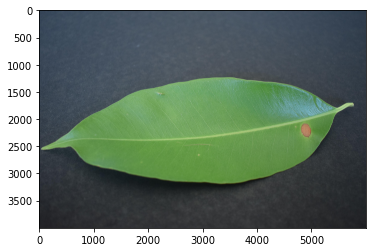

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

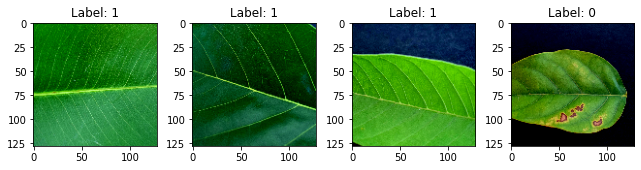

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:04:14] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:04:16] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2492610414877103 samples/sec                   batch loss = 0.5068313479423523 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.2550447443835844 samples/sec                   batch loss = 0.6740975975990295 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2597125651801069 samples/sec                   batch loss = 1.2209341526031494 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2540795931503335 samples/sec                   batch loss = 1.0266411304473877 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2556087801824571 samples/sec                   batch loss = 0.4145631194114685 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.261121282269541 samples/sec                   batch loss = 0.7694935202598572 | accuracy = 0.6166666666666667


Epoch[1] Batch[35] Speed: 1.2609943620891515 samples/sec                   batch loss = 0.5875039100646973 | accuracy = 0.6428571428571429


Epoch[1] Batch[40] Speed: 1.2573276783668754 samples/sec                   batch loss = 0.5443236827850342 | accuracy = 0.6375


Epoch[1] Batch[45] Speed: 1.252858305245135 samples/sec                   batch loss = 0.6847827434539795 | accuracy = 0.65


Epoch[1] Batch[50] Speed: 1.2578205864275882 samples/sec                   batch loss = 1.4358961582183838 | accuracy = 0.64


Epoch[1] Batch[55] Speed: 1.2607628625538938 samples/sec                   batch loss = 0.546708345413208 | accuracy = 0.6454545454545455


Epoch[1] Batch[60] Speed: 1.257024810354808 samples/sec                   batch loss = 0.6220006346702576 | accuracy = 0.65


Epoch[1] Batch[65] Speed: 1.2583531424334362 samples/sec                   batch loss = 0.4148935079574585 | accuracy = 0.6461538461538462


Epoch[1] Batch[70] Speed: 1.260067643363614 samples/sec                   batch loss = 0.2691870331764221 | accuracy = 0.65


Epoch[1] Batch[75] Speed: 1.2636323210948035 samples/sec                   batch loss = 0.3009926974773407 | accuracy = 0.65


Epoch[1] Batch[80] Speed: 1.2600312085967313 samples/sec                   batch loss = 0.7186883091926575 | accuracy = 0.653125


Epoch[1] Batch[85] Speed: 1.2628073146590495 samples/sec                   batch loss = 0.4233863353729248 | accuracy = 0.6470588235294118


Epoch[1] Batch[90] Speed: 1.25431333341009 samples/sec                   batch loss = 0.6818972229957581 | accuracy = 0.6388888888888888


Epoch[1] Batch[95] Speed: 1.2526132294920356 samples/sec                   batch loss = 1.0898314714431763 | accuracy = 0.6289473684210526


Epoch[1] Batch[100] Speed: 1.2554483940427394 samples/sec                   batch loss = 0.6794560551643372 | accuracy = 0.635


Epoch[1] Batch[105] Speed: 1.2624308369574673 samples/sec                   batch loss = 0.4131059944629669 | accuracy = 0.6357142857142857


Epoch[1] Batch[110] Speed: 1.2640261815878275 samples/sec                   batch loss = 0.6177982091903687 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.261956805934197 samples/sec                   batch loss = 0.3259778916835785 | accuracy = 0.6391304347826087


Epoch[1] Batch[120] Speed: 1.256268137198559 samples/sec                   batch loss = 0.9095057249069214 | accuracy = 0.6416666666666667


Epoch[1] Batch[125] Speed: 1.257020572180126 samples/sec                   batch loss = 0.46251362562179565 | accuracy = 0.642


Epoch[1] Batch[130] Speed: 1.2571742007226578 samples/sec                   batch loss = 0.8282372951507568 | accuracy = 0.6365384615384615


Epoch[1] Batch[135] Speed: 1.2629503818273589 samples/sec                   batch loss = 0.46729597449302673 | accuracy = 0.6351851851851852


Epoch[1] Batch[140] Speed: 1.2621613020925413 samples/sec                   batch loss = 0.7782338857650757 | accuracy = 0.6339285714285714


Epoch[1] Batch[145] Speed: 1.2567815853791822 samples/sec                   batch loss = 0.3668297529220581 | accuracy = 0.6413793103448275


Epoch[1] Batch[150] Speed: 1.2573691397755742 samples/sec                   batch loss = 0.47810080647468567 | accuracy = 0.6433333333333333


Epoch[1] Batch[155] Speed: 1.259457426090124 samples/sec                   batch loss = 0.6099671721458435 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.259574202282445 samples/sec                   batch loss = 0.41480451822280884 | accuracy = 0.646875


Epoch[1] Batch[165] Speed: 1.2588055794298945 samples/sec                   batch loss = 0.5018633604049683 | accuracy = 0.646969696969697


Epoch[1] Batch[170] Speed: 1.263388340258774 samples/sec                   batch loss = 0.37722069025039673 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.2584038271425293 samples/sec                   batch loss = 0.7399784326553345 | accuracy = 0.6485714285714286


Epoch[1] Batch[180] Speed: 1.2594928821588678 samples/sec                   batch loss = 1.2465472221374512 | accuracy = 0.6472222222222223


Epoch[1] Batch[185] Speed: 1.257450657108256 samples/sec                   batch loss = 1.1671545505523682 | accuracy = 0.6459459459459459


Epoch[1] Batch[190] Speed: 1.2573273956848379 samples/sec                   batch loss = 0.9746675491333008 | accuracy = 0.6447368421052632


Epoch[1] Batch[195] Speed: 1.2579845033780763 samples/sec                   batch loss = 0.5964074730873108 | accuracy = 0.6435897435897436


Epoch[1] Batch[200] Speed: 1.2574896760804664 samples/sec                   batch loss = 0.852908194065094 | accuracy = 0.64


Epoch[1] Batch[205] Speed: 1.2543481253093869 samples/sec                   batch loss = 0.7540591955184937 | accuracy = 0.6426829268292683


Epoch[1] Batch[210] Speed: 1.2558267342210963 samples/sec                   batch loss = 0.5471680760383606 | accuracy = 0.6392857142857142


Epoch[1] Batch[215] Speed: 1.258488593935959 samples/sec                   batch loss = 0.5134612321853638 | accuracy = 0.6383720930232558


Epoch[1] Batch[220] Speed: 1.253805085404423 samples/sec                   batch loss = 0.5650599002838135 | accuracy = 0.6375


Epoch[1] Batch[225] Speed: 1.2585745051211028 samples/sec                   batch loss = 0.6048739552497864 | accuracy = 0.6366666666666667


Epoch[1] Batch[230] Speed: 1.2557925182316616 samples/sec                   batch loss = 0.6686793565750122 | accuracy = 0.6380434782608696


Epoch[1] Batch[235] Speed: 1.2533943449685012 samples/sec                   batch loss = 0.7256397008895874 | accuracy = 0.6361702127659574


Epoch[1] Batch[240] Speed: 1.2607684524129348 samples/sec                   batch loss = 0.680172324180603 | accuracy = 0.6364583333333333


Epoch[1] Batch[245] Speed: 1.2548017218915917 samples/sec                   batch loss = 0.5547823309898376 | accuracy = 0.636734693877551


Epoch[1] Batch[250] Speed: 1.2629824219079349 samples/sec                   batch loss = 0.3865276873111725 | accuracy = 0.639


Epoch[1] Batch[255] Speed: 1.2532001683062683 samples/sec                   batch loss = 0.3426367938518524 | accuracy = 0.638235294117647


Epoch[1] Batch[260] Speed: 1.2573937352214857 samples/sec                   batch loss = 0.6284536719322205 | accuracy = 0.6375


Epoch[1] Batch[265] Speed: 1.2548746469144445 samples/sec                   batch loss = 0.8291949033737183 | accuracy = 0.6396226415094339


Epoch[1] Batch[270] Speed: 1.2586108556920743 samples/sec                   batch loss = 0.3885685205459595 | accuracy = 0.6416666666666667


Epoch[1] Batch[275] Speed: 1.2553610304348364 samples/sec                   batch loss = 0.4187513589859009 | accuracy = 0.6454545454545455


Epoch[1] Batch[280] Speed: 1.251854477241643 samples/sec                   batch loss = 0.5086221694946289 | accuracy = 0.6455357142857143


Epoch[1] Batch[285] Speed: 1.2578521781435235 samples/sec                   batch loss = 0.6507825255393982 | accuracy = 0.6464912280701754


Epoch[1] Batch[290] Speed: 1.2551647415244553 samples/sec                   batch loss = 0.346843421459198 | accuracy = 0.6456896551724138


Epoch[1] Batch[295] Speed: 1.2584702803208896 samples/sec                   batch loss = 0.2552614212036133 | accuracy = 0.6474576271186441


Epoch[1] Batch[300] Speed: 1.257481853242207 samples/sec                   batch loss = 0.32854869961738586 | accuracy = 0.6508333333333334


Epoch[1] Batch[305] Speed: 1.2607299876062752 samples/sec                   batch loss = 0.7435846328735352 | accuracy = 0.6516393442622951


Epoch[1] Batch[310] Speed: 1.2603234084800037 samples/sec                   batch loss = 0.4461685121059418 | accuracy = 0.6540322580645161


Epoch[1] Batch[315] Speed: 1.2611334163804968 samples/sec                   batch loss = 0.4466288089752197 | accuracy = 0.6563492063492063


Epoch[1] Batch[320] Speed: 1.2581598795625706 samples/sec                   batch loss = 0.46384313702583313 | accuracy = 0.6578125


Epoch[1] Batch[325] Speed: 1.2494846137822553 samples/sec                   batch loss = 0.648036003112793 | accuracy = 0.66


Epoch[1] Batch[330] Speed: 1.2509243501365024 samples/sec                   batch loss = 1.2600762844085693 | accuracy = 0.6598484848484848


Epoch[1] Batch[335] Speed: 1.255913128491202 samples/sec                   batch loss = 1.486106038093567 | accuracy = 0.6597014925373135


Epoch[1] Batch[340] Speed: 1.2542197518415719 samples/sec                   batch loss = 1.5746726989746094 | accuracy = 0.6580882352941176


Epoch[1] Batch[345] Speed: 1.2558997784368895 samples/sec                   batch loss = 0.7262581586837769 | accuracy = 0.6608695652173913


Epoch[1] Batch[350] Speed: 1.2586698708306394 samples/sec                   batch loss = 0.5977168679237366 | accuracy = 0.66


Epoch[1] Batch[355] Speed: 1.2554579765977625 samples/sec                   batch loss = 0.5644828081130981 | accuracy = 0.6591549295774648


Epoch[1] Batch[360] Speed: 1.2509226712779042 samples/sec                   batch loss = 0.4434943199157715 | accuracy = 0.6597222222222222


Epoch[1] Batch[365] Speed: 1.251587104961949 samples/sec                   batch loss = 0.4699811339378357 | accuracy = 0.660958904109589


Epoch[1] Batch[370] Speed: 1.2509578349797816 samples/sec                   batch loss = 0.6645886898040771 | accuracy = 0.6608108108108108


Epoch[1] Batch[375] Speed: 1.2517464125881226 samples/sec                   batch loss = 0.4362698495388031 | accuracy = 0.6606666666666666


Epoch[1] Batch[380] Speed: 1.2526164092503527 samples/sec                   batch loss = 0.7516417503356934 | accuracy = 0.6611842105263158


Epoch[1] Batch[385] Speed: 1.2584731122883812 samples/sec                   batch loss = 0.5328142642974854 | accuracy = 0.6603896103896104


Epoch[1] Batch[390] Speed: 1.2519082830235901 samples/sec                   batch loss = 0.5423385500907898 | accuracy = 0.6602564102564102


Epoch[1] Batch[395] Speed: 1.2507135021047977 samples/sec                   batch loss = 0.581500232219696 | accuracy = 0.6613924050632911


Epoch[1] Batch[400] Speed: 1.261001565239286 samples/sec                   batch loss = 0.30108141899108887 | accuracy = 0.663125


Epoch[1] Batch[405] Speed: 1.2600277071846566 samples/sec                   batch loss = 0.7726691961288452 | accuracy = 0.6635802469135802


Epoch[1] Batch[410] Speed: 1.2581053463877048 samples/sec                   batch loss = 0.5203696489334106 | accuracy = 0.6634146341463415


Epoch[1] Batch[415] Speed: 1.247490366036339 samples/sec                   batch loss = 0.6744426488876343 | accuracy = 0.6626506024096386


Epoch[1] Batch[420] Speed: 1.2516173572182747 samples/sec                   batch loss = 0.6622173190116882 | accuracy = 0.6625


Epoch[1] Batch[425] Speed: 1.2573868559385375 samples/sec                   batch loss = 0.45476433634757996 | accuracy = 0.6623529411764706


Epoch[1] Batch[430] Speed: 1.266967360812661 samples/sec                   batch loss = 0.46943360567092896 | accuracy = 0.6604651162790698


Epoch[1] Batch[435] Speed: 1.2625501604562672 samples/sec                   batch loss = 0.5750415325164795 | accuracy = 0.6597701149425287


Epoch[1] Batch[440] Speed: 1.2567716060318568 samples/sec                   batch loss = 0.8740527629852295 | accuracy = 0.6573863636363636


Epoch[1] Batch[445] Speed: 1.2604802129618402 samples/sec                   batch loss = 0.6116687655448914 | accuracy = 0.6573033707865169


Epoch[1] Batch[450] Speed: 1.2545669552649483 samples/sec                   batch loss = 0.3228289783000946 | accuracy = 0.6566666666666666


Epoch[1] Batch[455] Speed: 1.2504251815709213 samples/sec                   batch loss = 0.558053731918335 | accuracy = 0.6582417582417582


Epoch[1] Batch[460] Speed: 1.2560621606880888 samples/sec                   batch loss = 0.3994559645652771 | accuracy = 0.6603260869565217


Epoch[1] Batch[465] Speed: 1.2521444853287456 samples/sec                   batch loss = 0.7092806696891785 | accuracy = 0.6586021505376344


Epoch[1] Batch[470] Speed: 1.2579038599539236 samples/sec                   batch loss = 0.2638823091983795 | accuracy = 0.6590425531914894


Epoch[1] Batch[475] Speed: 1.260732356061041 samples/sec                   batch loss = 0.4418307840824127 | accuracy = 0.6594736842105263


Epoch[1] Batch[480] Speed: 1.2527358489227634 samples/sec                   batch loss = 0.9969323873519897 | accuracy = 0.6588541666666666


Epoch[1] Batch[485] Speed: 1.2590783128072514 samples/sec                   batch loss = 0.49579665064811707 | accuracy = 0.6577319587628866


Epoch[1] Batch[490] Speed: 1.263782715031627 samples/sec                   batch loss = 0.5375201106071472 | accuracy = 0.6566326530612245


Epoch[1] Batch[495] Speed: 1.256307176890895 samples/sec                   batch loss = 0.8149915933609009 | accuracy = 0.657070707070707


Epoch[1] Batch[500] Speed: 1.2587143482960383 samples/sec                   batch loss = 0.3182201087474823 | accuracy = 0.6575


Epoch[1] Batch[505] Speed: 1.2609463116010227 samples/sec                   batch loss = 0.383200466632843 | accuracy = 0.6603960396039604


Epoch[1] Batch[510] Speed: 1.2590208655426252 samples/sec                   batch loss = 0.3713188171386719 | accuracy = 0.6607843137254902


Epoch[1] Batch[515] Speed: 1.2567146514697312 samples/sec                   batch loss = 0.40557581186294556 | accuracy = 0.6621359223300971


Epoch[1] Batch[520] Speed: 1.2600518389332453 samples/sec                   batch loss = 0.6666935682296753 | accuracy = 0.6615384615384615


Epoch[1] Batch[525] Speed: 1.2574311485301841 samples/sec                   batch loss = 0.5270435810089111 | accuracy = 0.6623809523809524


Epoch[1] Batch[530] Speed: 1.2586942338936928 samples/sec                   batch loss = 0.6927084922790527 | accuracy = 0.6632075471698113


Epoch[1] Batch[535] Speed: 1.260523966101155 samples/sec                   batch loss = 0.4561154842376709 | accuracy = 0.6635514018691588


Epoch[1] Batch[540] Speed: 1.2542798562347792 samples/sec                   batch loss = 0.4008846580982208 | accuracy = 0.663425925925926


Epoch[1] Batch[545] Speed: 1.2533045518491028 samples/sec                   batch loss = 0.5561978220939636 | accuracy = 0.6628440366972477


Epoch[1] Batch[550] Speed: 1.2549992115681357 samples/sec                   batch loss = 0.33649942278862 | accuracy = 0.6640909090909091


Epoch[1] Batch[555] Speed: 1.2584691475374619 samples/sec                   batch loss = 0.6670427322387695 | accuracy = 0.663963963963964


Epoch[1] Batch[560] Speed: 1.2616779852998397 samples/sec                   batch loss = 0.6757188439369202 | accuracy = 0.6642857142857143


Epoch[1] Batch[565] Speed: 1.2623550364510951 samples/sec                   batch loss = 0.35779276490211487 | accuracy = 0.6632743362831859


Epoch[1] Batch[570] Speed: 1.262749146449167 samples/sec                   batch loss = 0.9181491732597351 | accuracy = 0.6614035087719298


Epoch[1] Batch[575] Speed: 1.2643383406324942 samples/sec                   batch loss = 0.4057064652442932 | accuracy = 0.6621739130434783


Epoch[1] Batch[580] Speed: 1.266461810028947 samples/sec                   batch loss = 0.5040715932846069 | accuracy = 0.6625


Epoch[1] Batch[585] Speed: 1.2672440255920023 samples/sec                   batch loss = 0.49188143014907837 | accuracy = 0.6628205128205128


Epoch[1] Batch[590] Speed: 1.2651202240855972 samples/sec                   batch loss = 0.4275798499584198 | accuracy = 0.6635593220338983


Epoch[1] Batch[595] Speed: 1.2583749448525798 samples/sec                   batch loss = 0.2679285705089569 | accuracy = 0.6655462184873949


Epoch[1] Batch[600] Speed: 1.2639829468090549 samples/sec                   batch loss = 0.5725871324539185 | accuracy = 0.6666666666666666


Epoch[1] Batch[605] Speed: 1.2641321859718924 samples/sec                   batch loss = 0.22475092113018036 | accuracy = 0.6677685950413224


Epoch[1] Batch[610] Speed: 1.263842501804928 samples/sec                   batch loss = 0.49826666712760925 | accuracy = 0.6672131147540984


Epoch[1] Batch[615] Speed: 1.2632565879259163 samples/sec                   batch loss = 0.39447370171546936 | accuracy = 0.6682926829268293


Epoch[1] Batch[620] Speed: 1.2687659732796501 samples/sec                   batch loss = 0.5353689193725586 | accuracy = 0.6685483870967742


Epoch[1] Batch[625] Speed: 1.2611988308445705 samples/sec                   batch loss = 0.36700475215911865 | accuracy = 0.6692


Epoch[1] Batch[630] Speed: 1.2639026750968951 samples/sec                   batch loss = 0.37113872170448303 | accuracy = 0.6702380952380952


Epoch[1] Batch[635] Speed: 1.2636387930081312 samples/sec                   batch loss = 0.5468555688858032 | accuracy = 0.6716535433070866


Epoch[1] Batch[640] Speed: 1.2629886019324523 samples/sec                   batch loss = 1.0311813354492188 | accuracy = 0.671875


Epoch[1] Batch[645] Speed: 1.2625559562005508 samples/sec                   batch loss = 0.5559801459312439 | accuracy = 0.6728682170542636


Epoch[1] Batch[650] Speed: 1.2586198256364738 samples/sec                   batch loss = 0.26147979497909546 | accuracy = 0.6734615384615384


Epoch[1] Batch[655] Speed: 1.2628402980346025 samples/sec                   batch loss = 0.5232371687889099 | accuracy = 0.6740458015267176


Epoch[1] Batch[660] Speed: 1.2563868630220458 samples/sec                   batch loss = 0.3768960237503052 | accuracy = 0.6757575757575758


Epoch[1] Batch[665] Speed: 1.2567127687624344 samples/sec                   batch loss = 0.3371065855026245 | accuracy = 0.6763157894736842


Epoch[1] Batch[670] Speed: 1.2680830839577046 samples/sec                   batch loss = 0.7399234771728516 | accuracy = 0.6761194029850747


Epoch[1] Batch[675] Speed: 1.2609555991810697 samples/sec                   batch loss = 0.9248389005661011 | accuracy = 0.6774074074074075


Epoch[1] Batch[680] Speed: 1.2558139500068677 samples/sec                   batch loss = 0.47493061423301697 | accuracy = 0.6764705882352942


Epoch[1] Batch[685] Speed: 1.261202907622756 samples/sec                   batch loss = 0.3842310607433319 | accuracy = 0.6762773722627737


Epoch[1] Batch[690] Speed: 1.259357970652991 samples/sec                   batch loss = 0.30650991201400757 | accuracy = 0.6771739130434783


Epoch[1] Batch[695] Speed: 1.2616036033407514 samples/sec                   batch loss = 0.33466702699661255 | accuracy = 0.676978417266187


Epoch[1] Batch[700] Speed: 1.267417301651406 samples/sec                   batch loss = 0.27994951605796814 | accuracy = 0.6775


Epoch[1] Batch[705] Speed: 1.2620003768576318 samples/sec                   batch loss = 0.776336669921875 | accuracy = 0.6776595744680851


Epoch[1] Batch[710] Speed: 1.2628013265076552 samples/sec                   batch loss = 0.3039086163043976 | accuracy = 0.678169014084507


Epoch[1] Batch[715] Speed: 1.255903350958822 samples/sec                   batch loss = 0.5461122989654541 | accuracy = 0.6797202797202797


Epoch[1] Batch[720] Speed: 1.2618810623401986 samples/sec                   batch loss = 0.5724243521690369 | accuracy = 0.6784722222222223


Epoch[1] Batch[725] Speed: 1.260822363936721 samples/sec                   batch loss = 1.7029634714126587 | accuracy = 0.6789655172413793


Epoch[1] Batch[730] Speed: 1.2609439423423012 samples/sec                   batch loss = 0.3727360963821411 | accuracy = 0.6794520547945205


Epoch[1] Batch[735] Speed: 1.2620349319730781 samples/sec                   batch loss = 0.3113008439540863 | accuracy = 0.6792517006802721


Epoch[1] Batch[740] Speed: 1.2594665972018386 samples/sec                   batch loss = 0.5159471035003662 | accuracy = 0.6793918918918919


Epoch[1] Batch[745] Speed: 1.261435991462616 samples/sec                   batch loss = 0.41916409134864807 | accuracy = 0.6802013422818792


Epoch[1] Batch[750] Speed: 1.2608292808631094 samples/sec                   batch loss = 0.31877797842025757 | accuracy = 0.6813333333333333


Epoch[1] Batch[755] Speed: 1.2588897391264677 samples/sec                   batch loss = 0.9676374793052673 | accuracy = 0.6817880794701987


Epoch[1] Batch[760] Speed: 1.253483963651002 samples/sec                   batch loss = 0.9334334135055542 | accuracy = 0.68125


Epoch[1] Batch[765] Speed: 1.2580937421871636 samples/sec                   batch loss = 0.2679675221443176 | accuracy = 0.6820261437908497


Epoch[1] Batch[770] Speed: 1.2592091949833728 samples/sec                   batch loss = 0.5159052014350891 | accuracy = 0.6824675324675324


Epoch[1] Batch[775] Speed: 1.2613546204327797 samples/sec                   batch loss = 0.5854052901268005 | accuracy = 0.6835483870967742


Epoch[1] Batch[780] Speed: 1.2567215233992364 samples/sec                   batch loss = 0.20261067152023315 | accuracy = 0.6849358974358974


Epoch[1] Batch[785] Speed: 1.2609421417116273 samples/sec                   batch loss = 0.28700965642929077 | accuracy = 0.685031847133758


[Epoch 1] training: accuracy=0.6855964467005076
[Epoch 1] time cost: 653.5161406993866
[Epoch 1] validation: validation accuracy=0.7044444444444444


Epoch[2] Batch[5] Speed: 1.2668043469019417 samples/sec                   batch loss = 0.22133882343769073 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2738282422998617 samples/sec                   batch loss = 0.4557391107082367 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.258968619539959 samples/sec                   batch loss = 0.550126314163208 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2617746759810817 samples/sec                   batch loss = 0.173629030585289 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2593417113720837 samples/sec                   batch loss = 0.25354981422424316 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.2641867665906648 samples/sec                   batch loss = 0.3007153570652008 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2634977583878768 samples/sec                   batch loss = 0.520081639289856 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.2625569063276412 samples/sec                   batch loss = 1.2921651601791382 | accuracy = 0.775


Epoch[2] Batch[45] Speed: 1.261318869815104 samples/sec                   batch loss = 0.8556192517280579 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.2634421906391262 samples/sec                   batch loss = 0.2626345455646515 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2710513801340189 samples/sec                   batch loss = 0.36627981066703796 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.262289122107539 samples/sec                   batch loss = 0.41136857867240906 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.2650138631730605 samples/sec                   batch loss = 0.17232224345207214 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.2635109849934303 samples/sec                   batch loss = 0.7886530756950378 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.2661426773565558 samples/sec                   batch loss = 0.759160578250885 | accuracy = 0.7666666666666667


Epoch[2] Batch[80] Speed: 1.266592797507886 samples/sec                   batch loss = 0.2408760040998459 | accuracy = 0.759375


Epoch[2] Batch[85] Speed: 1.2622133386177539 samples/sec                   batch loss = 0.3896799385547638 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.2580109151681005 samples/sec                   batch loss = 0.5534177422523499 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.256295511764786 samples/sec                   batch loss = 0.29306915402412415 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.2602189884921713 samples/sec                   batch loss = 0.7663564085960388 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.261688232481545 samples/sec                   batch loss = 0.5296121835708618 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.2623546565216102 samples/sec                   batch loss = 0.7570261359214783 | accuracy = 0.7295454545454545


Epoch[2] Batch[115] Speed: 1.2595964253058125 samples/sec                   batch loss = 0.29638949036598206 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.2563670111041434 samples/sec                   batch loss = 0.38598930835723877 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.2681458664169865 samples/sec                   batch loss = 0.25465232133865356 | accuracy = 0.742


Epoch[2] Batch[130] Speed: 1.270935258283945 samples/sec                   batch loss = 0.4715944826602936 | accuracy = 0.7423076923076923


Epoch[2] Batch[135] Speed: 1.2716700913215186 samples/sec                   batch loss = 0.6526123285293579 | accuracy = 0.7407407407407407


Epoch[2] Batch[140] Speed: 1.2711003001673389 samples/sec                   batch loss = 0.3448876142501831 | accuracy = 0.7410714285714286


Epoch[2] Batch[145] Speed: 1.2635905407792105 samples/sec                   batch loss = 0.18716618418693542 | accuracy = 0.746551724137931


Epoch[2] Batch[150] Speed: 1.2571339767460559 samples/sec                   batch loss = 1.2227023839950562 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2574959909727086 samples/sec                   batch loss = 0.6971769332885742 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.2598954248444545 samples/sec                   batch loss = 0.3466652035713196 | accuracy = 0.740625


Epoch[2] Batch[165] Speed: 1.2649970759995814 samples/sec                   batch loss = 0.5210014581680298 | accuracy = 0.7393939393939394


Epoch[2] Batch[170] Speed: 1.2588710359991813 samples/sec                   batch loss = 0.3185342848300934 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.2638136549326178 samples/sec                   batch loss = 0.3012532889842987 | accuracy = 0.7371428571428571


Epoch[2] Batch[180] Speed: 1.2651443604863184 samples/sec                   batch loss = 0.8051835894584656 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.2594292517576196 samples/sec                   batch loss = 0.4723842740058899 | accuracy = 0.7337837837837838


Epoch[2] Batch[190] Speed: 1.2576265443712997 samples/sec                   batch loss = 0.5526211261749268 | accuracy = 0.7342105263157894


Epoch[2] Batch[195] Speed: 1.2632471713024538 samples/sec                   batch loss = 0.6173955798149109 | accuracy = 0.7307692307692307


Epoch[2] Batch[200] Speed: 1.2575845946558777 samples/sec                   batch loss = 0.3185751140117645 | accuracy = 0.73


Epoch[2] Batch[205] Speed: 1.2564814269766542 samples/sec                   batch loss = 0.3931189477443695 | accuracy = 0.7329268292682927


Epoch[2] Batch[210] Speed: 1.2621481986803473 samples/sec                   batch loss = 0.3252611458301544 | accuracy = 0.7333333333333333


Epoch[2] Batch[215] Speed: 1.2593897341803821 samples/sec                   batch loss = 0.34819450974464417 | accuracy = 0.7372093023255814


Epoch[2] Batch[220] Speed: 1.2592942593599368 samples/sec                   batch loss = 0.6293067336082458 | accuracy = 0.7329545454545454


Epoch[2] Batch[225] Speed: 1.2673280729231897 samples/sec                   batch loss = 0.3330731987953186 | accuracy = 0.7333333333333333


Epoch[2] Batch[230] Speed: 1.2619165600854696 samples/sec                   batch loss = 0.14762179553508759 | accuracy = 0.7326086956521739


Epoch[2] Batch[235] Speed: 1.2586359718585913 samples/sec                   batch loss = 0.21628455817699432 | accuracy = 0.7351063829787234


Epoch[2] Batch[240] Speed: 1.259865338747498 samples/sec                   batch loss = 0.22572240233421326 | accuracy = 0.7395833333333334


Epoch[2] Batch[245] Speed: 1.2561382418603635 samples/sec                   batch loss = 0.5786741375923157 | accuracy = 0.7408163265306122


Epoch[2] Batch[250] Speed: 1.2563233579083404 samples/sec                   batch loss = 1.9465398788452148 | accuracy = 0.738


Epoch[2] Batch[255] Speed: 1.262974340428668 samples/sec                   batch loss = 0.8188835382461548 | accuracy = 0.7382352941176471


Epoch[2] Batch[260] Speed: 1.2597666702183266 samples/sec                   batch loss = 0.4994759261608124 | accuracy = 0.739423076923077


Epoch[2] Batch[265] Speed: 1.262583415449993 samples/sec                   batch loss = 0.33328983187675476 | accuracy = 0.7405660377358491


Epoch[2] Batch[270] Speed: 1.2617041728728295 samples/sec                   batch loss = 0.5956160426139832 | accuracy = 0.7407407407407407


Epoch[2] Batch[275] Speed: 1.265404004272918 samples/sec                   batch loss = 0.27698609232902527 | accuracy = 0.7418181818181818


Epoch[2] Batch[280] Speed: 1.2592912346517178 samples/sec                   batch loss = 0.838114857673645 | accuracy = 0.7401785714285715


Epoch[2] Batch[285] Speed: 1.2654740624151197 samples/sec                   batch loss = 0.5326203107833862 | accuracy = 0.7412280701754386


Epoch[2] Batch[290] Speed: 1.267450622037749 samples/sec                   batch loss = 0.4366941750049591 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2591138420286894 samples/sec                   batch loss = 0.2524951696395874 | accuracy = 0.7423728813559322


Epoch[2] Batch[300] Speed: 1.2651441696811203 samples/sec                   batch loss = 0.6006953716278076 | accuracy = 0.7433333333333333


Epoch[2] Batch[305] Speed: 1.257796445768057 samples/sec                   batch loss = 0.28846409916877747 | accuracy = 0.7467213114754099


Epoch[2] Batch[310] Speed: 1.258526733278133 samples/sec                   batch loss = 0.6580629348754883 | accuracy = 0.7459677419354839


Epoch[2] Batch[315] Speed: 1.2616013264803527 samples/sec                   batch loss = 0.4244438707828522 | accuracy = 0.746031746031746


Epoch[2] Batch[320] Speed: 1.268835636510988 samples/sec                   batch loss = 0.6933383941650391 | accuracy = 0.74453125


Epoch[2] Batch[325] Speed: 1.2594419205968013 samples/sec                   batch loss = 0.40232378244400024 | accuracy = 0.7446153846153846


Epoch[2] Batch[330] Speed: 1.252552443099075 samples/sec                   batch loss = 0.4606032371520996 | accuracy = 0.7454545454545455


Epoch[2] Batch[335] Speed: 1.2581184603353959 samples/sec                   batch loss = 0.3432632386684418 | accuracy = 0.746268656716418


Epoch[2] Batch[340] Speed: 1.25881795237217 samples/sec                   batch loss = 0.46410536766052246 | accuracy = 0.7463235294117647


Epoch[2] Batch[345] Speed: 1.2575935499781496 samples/sec                   batch loss = 0.11549901962280273 | accuracy = 0.7456521739130435


Epoch[2] Batch[350] Speed: 1.2605217878427217 samples/sec                   batch loss = 0.38848909735679626 | accuracy = 0.7464285714285714


Epoch[2] Batch[355] Speed: 1.2567603088487835 samples/sec                   batch loss = 0.5429622530937195 | accuracy = 0.745774647887324


Epoch[2] Batch[360] Speed: 1.2627955285104202 samples/sec                   batch loss = 0.248444601893425 | accuracy = 0.7458333333333333


Epoch[2] Batch[365] Speed: 1.261970190146078 samples/sec                   batch loss = 1.6554044485092163 | accuracy = 0.7445205479452055


Epoch[2] Batch[370] Speed: 1.2597384820485635 samples/sec                   batch loss = 0.2756838798522949 | accuracy = 0.7439189189189189


Epoch[2] Batch[375] Speed: 1.250779611772013 samples/sec                   batch loss = 0.08376409113407135 | accuracy = 0.744


Epoch[2] Batch[380] Speed: 1.2537914990339047 samples/sec                   batch loss = 0.28174886107444763 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.258586873521262 samples/sec                   batch loss = 0.2743949592113495 | accuracy = 0.7454545454545455


Epoch[2] Batch[390] Speed: 1.2557972181197445 samples/sec                   batch loss = 0.8704155683517456 | accuracy = 0.7448717948717949


Epoch[2] Batch[395] Speed: 1.2614151260951527 samples/sec                   batch loss = 0.9139516353607178 | accuracy = 0.7449367088607595


Epoch[2] Batch[400] Speed: 1.2552501994854715 samples/sec                   batch loss = 0.2516811490058899 | accuracy = 0.745


Epoch[2] Batch[405] Speed: 1.254240004784546 samples/sec                   batch loss = 0.4763566851615906 | accuracy = 0.745679012345679


Epoch[2] Batch[410] Speed: 1.258251690896906 samples/sec                   batch loss = 0.5999191403388977 | accuracy = 0.7445121951219512


Epoch[2] Batch[415] Speed: 1.2584328995444887 samples/sec                   batch loss = 0.332846462726593 | accuracy = 0.7457831325301205


Epoch[2] Batch[420] Speed: 1.2565392073831456 samples/sec                   batch loss = 0.39064136147499084 | accuracy = 0.7470238095238095


Epoch[2] Batch[425] Speed: 1.2645976536539483 samples/sec                   batch loss = 0.36063048243522644 | accuracy = 0.7476470588235294


Epoch[2] Batch[430] Speed: 1.2586728925546673 samples/sec                   batch loss = 0.2611812651157379 | accuracy = 0.7494186046511628


Epoch[2] Batch[435] Speed: 1.2557903562949564 samples/sec                   batch loss = 0.6800483465194702 | accuracy = 0.7488505747126437


Epoch[2] Batch[440] Speed: 1.2570497690743065 samples/sec                   batch loss = 0.7684599757194519 | accuracy = 0.7477272727272727


Epoch[2] Batch[445] Speed: 1.25937007085545 samples/sec                   batch loss = 1.1170583963394165 | accuracy = 0.746629213483146


Epoch[2] Batch[450] Speed: 1.2531323985266754 samples/sec                   batch loss = 0.3873935043811798 | accuracy = 0.7472222222222222


Epoch[2] Batch[455] Speed: 1.2634691175508188 samples/sec                   batch loss = 0.27003103494644165 | accuracy = 0.7478021978021978


Epoch[2] Batch[460] Speed: 1.2559352225144658 samples/sec                   batch loss = 0.6129937767982483 | accuracy = 0.7478260869565218


Epoch[2] Batch[465] Speed: 1.253656775656013 samples/sec                   batch loss = 0.45485764741897583 | accuracy = 0.7489247311827957


Epoch[2] Batch[470] Speed: 1.2575673442366573 samples/sec                   batch loss = 0.41303274035453796 | accuracy = 0.75


Epoch[2] Batch[475] Speed: 1.2560638533704145 samples/sec                   batch loss = 0.45582664012908936 | accuracy = 0.7505263157894737


Epoch[2] Batch[480] Speed: 1.2550620195533406 samples/sec                   batch loss = 0.5082288980484009 | accuracy = 0.7505208333333333


Epoch[2] Batch[485] Speed: 1.2567627565545472 samples/sec                   batch loss = 0.99764084815979 | accuracy = 0.7510309278350515


Epoch[2] Batch[490] Speed: 1.2630089489020575 samples/sec                   batch loss = 0.7368934154510498 | accuracy = 0.7510204081632653


Epoch[2] Batch[495] Speed: 1.2592215758613252 samples/sec                   batch loss = 0.3579215705394745 | accuracy = 0.7515151515151515


Epoch[2] Batch[500] Speed: 1.2624048091909894 samples/sec                   batch loss = 0.5550524592399597 | accuracy = 0.752


Epoch[2] Batch[505] Speed: 1.2612694671244578 samples/sec                   batch loss = 0.1910896897315979 | accuracy = 0.752970297029703


Epoch[2] Batch[510] Speed: 1.261803619645827 samples/sec                   batch loss = 0.5076240301132202 | accuracy = 0.7534313725490196


Epoch[2] Batch[515] Speed: 1.2594440005798306 samples/sec                   batch loss = 0.7695335149765015 | accuracy = 0.753883495145631


Epoch[2] Batch[520] Speed: 1.2615277124226059 samples/sec                   batch loss = 0.41650906205177307 | accuracy = 0.7528846153846154


Epoch[2] Batch[525] Speed: 1.2638025163937414 samples/sec                   batch loss = 0.8588354587554932 | accuracy = 0.7533333333333333


Epoch[2] Batch[530] Speed: 1.2604086234669933 samples/sec                   batch loss = 0.4980977475643158 | accuracy = 0.7547169811320755


Epoch[2] Batch[535] Speed: 1.2556568946179363 samples/sec                   batch loss = 0.4433046281337738 | accuracy = 0.755607476635514


Epoch[2] Batch[540] Speed: 1.2543760727611 samples/sec                   batch loss = 0.5641759634017944 | accuracy = 0.7537037037037037


Epoch[2] Batch[545] Speed: 1.2607944127469282 samples/sec                   batch loss = 0.36315450072288513 | accuracy = 0.7527522935779817


Epoch[2] Batch[550] Speed: 1.259622526538862 samples/sec                   batch loss = 0.27579453587532043 | accuracy = 0.7518181818181818


Epoch[2] Batch[555] Speed: 1.2555510853114165 samples/sec                   batch loss = 0.27229729294776917 | accuracy = 0.7504504504504504


Epoch[2] Batch[560] Speed: 1.2581716736909994 samples/sec                   batch loss = 1.178598165512085 | accuracy = 0.7491071428571429


Epoch[2] Batch[565] Speed: 1.2564770042654663 samples/sec                   batch loss = 0.3614944517612457 | accuracy = 0.7486725663716814


Epoch[2] Batch[570] Speed: 1.2545227704130255 samples/sec                   batch loss = 0.4352248013019562 | accuracy = 0.7486842105263158


Epoch[2] Batch[575] Speed: 1.257026505632683 samples/sec                   batch loss = 0.42415547370910645 | accuracy = 0.7482608695652174


Epoch[2] Batch[580] Speed: 1.264270504135785 samples/sec                   batch loss = 0.3335297405719757 | accuracy = 0.7478448275862069


Epoch[2] Batch[585] Speed: 1.2607436300277206 samples/sec                   batch loss = 0.332976371049881 | accuracy = 0.7465811965811966


Epoch[2] Batch[590] Speed: 1.2657905660773099 samples/sec                   batch loss = 0.38901621103286743 | accuracy = 0.7483050847457627


Epoch[2] Batch[595] Speed: 1.2586518352170857 samples/sec                   batch loss = 0.8975855708122253 | accuracy = 0.7483193277310924


Epoch[2] Batch[600] Speed: 1.2557291671734452 samples/sec                   batch loss = 0.5683611035346985 | accuracy = 0.7491666666666666


Epoch[2] Batch[605] Speed: 1.256649230698938 samples/sec                   batch loss = 0.5275610685348511 | accuracy = 0.7504132231404959


Epoch[2] Batch[610] Speed: 1.2571910635300814 samples/sec                   batch loss = 1.098713994026184 | accuracy = 0.7487704918032787


Epoch[2] Batch[615] Speed: 1.2544025208253784 samples/sec                   batch loss = 0.32337841391563416 | accuracy = 0.7491869918699187


Epoch[2] Batch[620] Speed: 1.255693828707664 samples/sec                   batch loss = 0.3868730068206787 | accuracy = 0.75


Epoch[2] Batch[625] Speed: 1.2538539050690036 samples/sec                   batch loss = 0.3891048729419708 | accuracy = 0.7508


Epoch[2] Batch[630] Speed: 1.2555664951488774 samples/sec                   batch loss = 0.2689998745918274 | accuracy = 0.7492063492063492


Epoch[2] Batch[635] Speed: 1.2533962177461198 samples/sec                   batch loss = 0.6917510032653809 | accuracy = 0.7496062992125985


Epoch[2] Batch[640] Speed: 1.2538301975401718 samples/sec                   batch loss = 0.22558128833770752 | accuracy = 0.75


Epoch[2] Batch[645] Speed: 1.2617419380263082 samples/sec                   batch loss = 0.2880628705024719 | accuracy = 0.7511627906976744


Epoch[2] Batch[650] Speed: 1.2547526407091203 samples/sec                   batch loss = 0.6479461789131165 | accuracy = 0.7507692307692307


Epoch[2] Batch[655] Speed: 1.2579106505804332 samples/sec                   batch loss = 0.5891741514205933 | accuracy = 0.750763358778626


Epoch[2] Batch[660] Speed: 1.2525361720502806 samples/sec                   batch loss = 0.5762529373168945 | accuracy = 0.7492424242424243


Epoch[2] Batch[665] Speed: 1.2588016125838624 samples/sec                   batch loss = 0.5290663838386536 | accuracy = 0.749624060150376


Epoch[2] Batch[670] Speed: 1.2557833065530655 samples/sec                   batch loss = 0.47439897060394287 | accuracy = 0.7492537313432835


Epoch[2] Batch[675] Speed: 1.2565189742257776 samples/sec                   batch loss = 0.298471063375473 | accuracy = 0.7481481481481481


Epoch[2] Batch[680] Speed: 1.2635598972927389 samples/sec                   batch loss = 0.26751697063446045 | accuracy = 0.7485294117647059


Epoch[2] Batch[685] Speed: 1.2532662602611395 samples/sec                   batch loss = 0.29975661635398865 | accuracy = 0.7492700729927008


Epoch[2] Batch[690] Speed: 1.2602370690464613 samples/sec                   batch loss = 0.3044332265853882 | accuracy = 0.75


Epoch[2] Batch[695] Speed: 1.256701190236583 samples/sec                   batch loss = 0.08743268251419067 | accuracy = 0.7507194244604316


Epoch[2] Batch[700] Speed: 1.2533592314243451 samples/sec                   batch loss = 0.26212015748023987 | accuracy = 0.7510714285714286


Epoch[2] Batch[705] Speed: 1.255775316941274 samples/sec                   batch loss = 0.3675056993961334 | accuracy = 0.752127659574468


Epoch[2] Batch[710] Speed: 1.2569715056162536 samples/sec                   batch loss = 0.6953908801078796 | accuracy = 0.7517605633802817


Epoch[2] Batch[715] Speed: 1.2601837754986382 samples/sec                   batch loss = 0.27468010783195496 | accuracy = 0.7527972027972027


Epoch[2] Batch[720] Speed: 1.2674917004424642 samples/sec                   batch loss = 0.41494566202163696 | accuracy = 0.753125


Epoch[2] Batch[725] Speed: 1.266835530590509 samples/sec                   batch loss = 0.42041295766830444 | accuracy = 0.7531034482758621


Epoch[2] Batch[730] Speed: 1.2588985241204989 samples/sec                   batch loss = 0.331783264875412 | accuracy = 0.7534246575342466


Epoch[2] Batch[735] Speed: 1.2626429937762744 samples/sec                   batch loss = 0.507100522518158 | accuracy = 0.753061224489796


Epoch[2] Batch[740] Speed: 1.2620888569227018 samples/sec                   batch loss = 0.6913179159164429 | accuracy = 0.7533783783783784


Epoch[2] Batch[745] Speed: 1.2551342236439795 samples/sec                   batch loss = 0.22898027300834656 | accuracy = 0.7536912751677852


Epoch[2] Batch[750] Speed: 1.2527208826412695 samples/sec                   batch loss = 0.5734726786613464 | accuracy = 0.7536666666666667


Epoch[2] Batch[755] Speed: 1.2577628767036406 samples/sec                   batch loss = 0.3630245327949524 | accuracy = 0.7543046357615895


Epoch[2] Batch[760] Speed: 1.2582735841698216 samples/sec                   batch loss = 0.8908967971801758 | accuracy = 0.7542763157894737


Epoch[2] Batch[765] Speed: 1.2586718538353963 samples/sec                   batch loss = 0.0707285925745964 | accuracy = 0.7549019607843137


Epoch[2] Batch[770] Speed: 1.25509506902934 samples/sec                   batch loss = 0.2290675789117813 | accuracy = 0.7548701298701299


Epoch[2] Batch[775] Speed: 1.2578085159819918 samples/sec                   batch loss = 0.4710306227207184 | accuracy = 0.7548387096774194


Epoch[2] Batch[780] Speed: 1.251795445663137 samples/sec                   batch loss = 0.15269871056079865 | accuracy = 0.7548076923076923


Epoch[2] Batch[785] Speed: 1.2491761180138676 samples/sec                   batch loss = 0.5854890942573547 | accuracy = 0.7554140127388536


[Epoch 2] training: accuracy=0.7553934010152284
[Epoch 2] time cost: 643.9187798500061
[Epoch 2] validation: validation accuracy=0.7688888888888888


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)